In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import math

In [2]:
# Read file and create vocab
names = open('../names.txt').read().splitlines()
vocab = sorted(list(set(''.join(names))))
max_name_length = max(len(n) for n in names)
print(max_name_length)
print(vocab)

15
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
# Create simple tokenizer (tokenizes one name at a time)
stoi = {s: i+1 for i,s in enumerate(vocab)}
itos = {s: i for i,s in stoi.items()}
encode = lambda name: [stoi[n] for n in name]
decode = lambda tokens: ''.join(itos[t] for t in tokens)
print(stoi)
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
# Create training and test sets
import random
# Set the seed
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = names[:n1]
test_data = names[n1:] # there should be a validation dataset to train hyperparameters but this is meant to be quick and dirty
# print(len(train_data), len(test_data))
encoded_train_data = [encode(name) for name in train_data]
encoded_test_data = [encode(name) for name in test_data]

In [5]:
## Get batch of certain sizes
def get_batch(batch_size, train=True):
    x = torch.zeros(batch_size, max_name_length+1, dtype=torch.long) # +1 to account for start character
    y = torch.zeros(batch_size, max_name_length+1, dtype=torch.long) # +1 to account for start character
    if train:
        encoded_batch_names = random.sample(encoded_train_data, batch_size)
    else:
        encoded_batch_names = random.sample(encoded_test_data, batch_size)
        
    encoded_batch_names = random.sample(encoded_test_data, batch_size)
    decoded_batch_names = [decode(n) for n in encoded_batch_names]
    for idx,e_name in enumerate(encoded_batch_names):
        x[idx, 1:1+len(e_name)] = torch.tensor(e_name)
        y[idx, :len(e_name)] = torch.tensor(e_name)
        y[idx, len(e_name)+1:] = -1 

    return x, y #for checking that we are not getting garbage: decoded_batch_names, encoded_batch_names

In [6]:
# Checking batchifying
# x, y, decoded_batch, encoded_batch = get_batch(4)
# print(x)
# print(y)
# print(decoded_batch)
# print(encoded_batch)

In [7]:
class Bigram(nn.Module):
    def __init__(self,vocab_size):
        super(Bigram, self).__init__()
        self.bigram_embedding = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, targets = None):
        logits = self.bigram_embedding(x) # Outputs Batch, Time, Channel (Vocab Size) 
        if targets == None:
            loss = None
        else:
            self.B,self.T,self.C = logits.shape
            logits = logits.view(self.B*self.T,self.C)
            targets = targets.contiguous().view(self.B*self.T)
            loss = F.cross_entropy(logits, targets, ignore_index=-1)
        
        return logits, loss

    # """
    # Bigram Language Model 'neural net', simply a lookup table of logits for the
    # next character given a previous character.
    # """

    # def __init__(self, vocab_size):
    #     super().__init__()
    #     n = vocab_size
    #     self.logits = nn.Parameter(torch.zeros((n, n)))

    # def get_block_size(self):
    #     return 1 # this model only needs one previous character to predict the next

    # def forward(self, idx, targets=None):

    #      # 'forward pass', lol
    #     logits = self.logits[idx]

    #     # if we are given some desired targets also calculate the loss
    #     loss = None
    #     if targets is not None:
    #         loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

    #     return logits, loss
    
    # @torch.no_grad()
    # def generate(self, x, max_new_tokens):
    #     # x should have dimensions (B,T*C) where B is number of new names and T is time dimension (so just start character)
    #     # For names we will truncate anything new after the stop character
    #     block_size = 1
    #     for _ in range(max_new_tokens):
    #         x_cond = x if x.size(1) <= block_size else x[:, -block_size:]
    #         logits, _ = self(x_cond)
    #         # Take softmax along the channel dimension 
    #         probs = F.softmax(logits, dim=-1)
    #         # Sample from the distribution
    #         x_next = torch.multinomial(probs, num_samples = 1)
    #         # _, x_next = torch.topk(probs, k=1, dim=-1)
    #         x = torch.cat((x, x_next[0])) # x dimension B, T --> B, T+1
            
    #     return x

In [8]:
# # Check how the neural network is initializing
# xb, yb = get_batch(batch_size=4)
# vocab_size = len(vocab)
# model = Bigram(vocab_size)
# logits, loss = model(xb, yb)
# print(logits.shape)
# print(loss)

In [9]:
# Set up optimizer
vocab_size = len(vocab) + 1 # +1 for special characters
model = Bigram(vocab_size)
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
batch_size = 32

@torch.inference_mode()
def evaluate_loss(num_batches = 10):
    model.eval()
    loss_tr = []
    loss_te = []
    for n in range(num_batches):
        Xtr, Ytr = get_batch(batch_size)
        Xte, Yte = get_batch(batch_size, train=False)
        _, train_loss = model(Xtr, Ytr)
        _, test_loss = model(Xte, Yte)
        loss_tr.append(train_loss)
        loss_te.append(test_loss)
    
    mean_train_loss = torch.tensor(loss_tr).mean().item()
    mean_test_loss = torch.tensor(loss_te).mean().item()
    model.train()
    return(mean_train_loss, mean_test_loss)


In [19]:
# Training loop - update to evaluate loss on ongoing basis and printing results, understand whats going on in the bigram model - ie why isnt it working with embedding 

batch_size = 8

tr_loss = []
te_loss = []

for steps in range(2):
    xb, yb = get_batch(batch_size)
    print(xb)
    print(yb)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    ltr, lte = evaluate_loss()
    tr_loss.append(ltr)
    te_loss.append(lte)

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())


tensor([[ 0, 19,  9, 12, 22,  1, 14,  1,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 20,  1, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 11,  1,  4,  1, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 25, 21, 24, 21,  1, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 11, 15, 21, 18, 20, 14,  5, 25,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1, 13,  1,  1, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 13,  9,  3,  8, 15, 14, 14,  5,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 18, 25,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
tensor([[19,  9, 12, 22,  1, 14,  1,  0, -1, -1, -1, -1, -1, -1, -1, -1],
        [20,  1, 13,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [11,  1,  4,  1, 18,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [25, 21, 24, 21,  1, 14,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [11, 15, 21, 18, 20, 14,  5, 25,  0, -1, -1, -1, -1, -1, -1, -1],
        [ 1, 13,  1,  1, 12,  0, -1, 

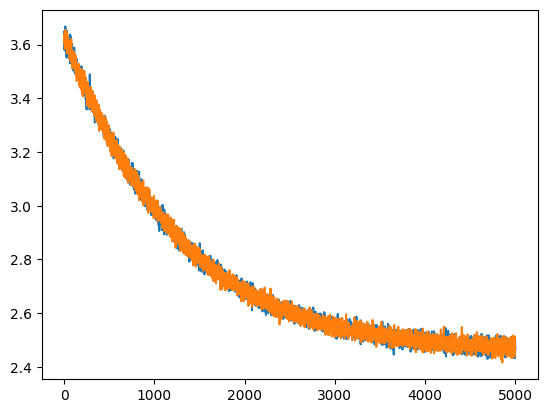

In [12]:
# Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss)
plt.plot(te_loss)

plt.show()

In [13]:
# # Infer from the model
# generated_names = decode(model.generate(torch.tensor([0]),max_new_tokens=10).tolist()[1:]) # We want to crop out the first letter which is a start token
# generated_names

In [14]:
@torch.no_grad()
def generate(model, idx, block_size=1):
    for _ in range(max_name_length):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        # input_tokens = input_tokens[-block_length:] if len(input_tokens) > block_length else input_tokens
        # logits, _ = model(input_tokens)
        logits = torch.squeeze(logits)
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
        # ouput_token = torch.squeeze(torch.multinomial(probs, 1))
        # x.append(ouput_token.tolist())
    return idx

In [15]:
def print_samples(num=10):
    """ samples from the model and pretty prints the decoded samples """
    X_init = torch.zeros(num, 1, dtype=torch.long)
    steps = max_name_length # we already start with <START> token (index 0) so its just len(vocab) instead of len(vocab) + 1
    X_samp = generate(model, X_init)[:,1:].tolist()
    # print(X_samp)
    for row in X_samp:
        crop_index = row.index(0) if 0 in row else len(row)
        # print(row, crop_index)
        row = row[:crop_index]
        print(decode(row))
    
    
    # train_samples, test_samples, new_samples = [], [], []
    # for i in range(X_samp.size(0)):
    #     # get the i'th row of sampled integers, as python list
    #     row = X_samp[i, 1:].tolist() # note: we need to crop out the first <START> token
    #     # token 0 is the <STOP> token, so we crop the output sequence at that point
    #     crop_index = row.index(0) if 0 in row else len(row)
    #     row = row[:crop_index]
    #     word_samp = decode(row)
    #     # separately track samples that we have and have not seen before
    #     # if train_dataset.contains(word_samp):
    #     #     train_samples.append(word_samp)
    #     # elif test_dataset.contains(word_samp):
    #     #     test_samples.append(word_samp)
    #     # else:
    #     #     new_samples.append(word_samp)
    #     new_samples.append(word_samp)
    # print('-'*80)
    # for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
    #     print(f"{len(lst)} samples that are {desc}:")
    #     for word in lst:
    #         print(word)
    # print('-'*80)

In [16]:
print_samples()

jal
kh
veyeireneietabh
lyl
lalle
wjonanoviangnck
ikepanelemirquk
zfr
katadr
liyquekacaelo


In [ ]:
import sys
sys.path.append("/Users/shwetank/code/makemore") 

In [ ]:
from makemore import create_datasets

In [ ]:
tr, te = create_datasets('../names.txt')

In [ ]:
tr[5]
# tr.decode(tr[1][0])

In [ ]:
# -----------------------------------------------------------------------------
# helper functions for creating the training and test Datasets that emit words
from torch.utils.data import Dataset
class CharDataset(Dataset):

    def __init__(self, words, chars, max_word_length):
        self.words = words
        self.chars = chars
        self.max_word_length = max_word_length
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()} # inverse mapping

    def __len__(self):
        return len(self.words)

    def contains(self, word):
        return word in self.words

    def get_vocab_size(self):
        return len(self.chars) + 1 # all the possible characters and special 0 token

    def get_output_length(self):
        return self.max_word_length + 1 # <START> token followed by words

    def encode(self, word):
        ix = torch.tensor([self.stoi[w] for w in word], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        word = self.words[idx]
        ix = self.encode(word)
        x = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1 # index -1 will mask the loss at the inactive locations
        return x, y

In [ ]:
def create_datasets(input_file):

    # preprocessing of the input text file
    with open(input_file, 'r') as f:
        data = f.read()
    words = data.splitlines()
    words = [w.strip() for w in words] # get rid of any leading or trailing white space
    words = [w for w in words if w] # get rid of any empty strings
    chars = sorted(list(set(''.join(words)))) # all the possible characters
    max_word_length = max(len(w) for w in words)
    print(f"number of examples in the dataset: {len(words)}")
    print(f"max word length: {max_word_length}")
    print(f"number of unique characters in the vocabulary: {len(chars)}")
    print("vocabulary:")
    print(''.join(chars))

    # partition the input data into a training and the test set
    test_set_size = min(1000, int(len(words) * 0.1)) # 10% of the training set, or up to 1000 examples
    rp = torch.randperm(len(words)).tolist()
    train_words = [words[i] for i in rp[:-test_set_size]]
    test_words = [words[i] for i in rp[-test_set_size:]]
    print(f"split up the dataset into {len(train_words)} training examples and {len(test_words)} test examples")

    # wrap in dataset objects
    train_dataset = CharDataset(train_words, chars, max_word_length)
    test_dataset = CharDataset(test_words, chars, max_word_length)

    return train_dataset, test_dataset

In [ ]:
train_data, test_data = create_datasets('../names.txt')


In [ ]:
from torch.utils.data.dataloader import DataLoader
class InfiniteDataLoader:
    """
    this is really hacky and I'm not proud of it, but there doesn't seem to be
    a better way in PyTorch to just create an infinite dataloader?
    """

    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

In [ ]:
train_dataset, test_dataset = create_datasets('../names.txt')

In [ ]:
# init dataloader
batch_loader = InfiniteDataLoader(train_dataset, batch_size=5, pin_memory=True)

In [ ]:
batch = batch_loader.next()
batch = [t for t in batch]
X, Y = batch
print(X)
print(Y)

In [ ]:
batch[0].shape, batch[1].shape

In [ ]:
train_dataset[0]

In [ ]:
# # Example training data with variable-length sequences
# training_data = ['hello', 'world', 'python', 'example', 'abc', 'xyz', 'encompass']
# encoded_data = [encode(name) for name in training_data]

# # Find the maximum sequence length
# block_size = max(len(seq) for seq in encoded_data)

# # Pad sequences to the maximum length
# padded_data = [seq + [0] * (block_size - len(seq)) for seq in encoded_data]

# padded_data_tensor = torch.tensor(padded_data)
# x  = padded_data_tensor[:,:block_size-1]
# y  = padded_data_tensor[:,1:block_size]
# padded_data_tensor,x,y

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self,vocab_size):
        super(TransformerDecoder, self).__init__()
        # self.embedding = nn.Embedding(vocab_size, d_model)
        # self.positional_encoding = PositionalEncoding(d_model, max_len)
        # self.transformer_decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        # self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, num_layers=num_layers)
        # self.fc = nn.Linear(d_model, vocab_size)
        self.bigram_embedding = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, targets = None):
        logits = self.bigram_embedding(x) # Outputs Batch, Time, Channel (Vocab Size) 
        if targets == None:
            loss = None
        else:
            self.B,self.T,self.C = logits.shape
            logits = logits.view(self.B*self.T,self.C)
            targets = targets.contiguous().view(self.B*self.T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, x, ntokens):
        # x should have dimensions (B,T*C) where B is number of new names and T is time dimension (so just start character)
        # For names we will truncate anything new after the stop character
        for n in range(ntokens):
            logits, loss = self(x)
            # Take softmax along the channel dimension 
            probs = F.softmax(logits, -1)
            # Sample from the distribution
            x_next = torch.multinomial(probs, num_samples = 1)
            x = torch.cat((x, x_next[0])) # x dimension B, T --> B, T+1
            
        return x

In [ ]:
vocab_size = len(vocab)
model = TransformerDecoder(vocab_size)
logits, loss = model(x, y)
print(logits.shape)
print(loss)
# output.shape # Shape is Batch, Time (including padding), Channel (Vocab size) of 28
# print(logits.view(7,8,-1)[:,-1,:].shape)

In [ ]:
# Print whatever we get out of untrained model
x = torch.zeros(1,1,dtype=torch.long)
print(decode(model.generate(x[:,0], ntokens=30).tolist()))

In [ ]:
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training loop
batch_size = 32

for steps in range(10000):
    xb, yb = get_batch(batch_size=32)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


In [ ]:
decode(model.generate(torch.tensor([0]),ntokens=17).tolist())

In [ ]:
vocab_size = len(vocab)
d_model = 2 # Start with 2D to see if its separating vowels and consonants
nhead = 2 # What does this do?
dim_feedforward = 200
num_layers = 1
model = TransformerDecoder(vocab_size, d_model, nhead, dim_feedforward, num_layers)


In [ ]:
x = torch.tensor([[ 6, 13, 13, 16,  0,  0,  0,  0],
        [16, 19, 13,  5,  0,  0,  0,  0],
        [26, 21,  9, 16, 15,  0,  0,  0],
        [25,  2, 14, 17, 13,  6,  0,  0],
        [ 3,  4,  0,  0,  0,  0,  0,  0],
        [26, 27,  0,  0,  0,  0,  0,  0],
        [15,  4, 16, 14, 17,  2, 20, 20]])

In [ ]:
x.shape

In [ ]:
x.view(-1)

In [ ]:
# Training loop
num_epochs = 10

In [ ]:
# memory_mask = torch.triu(torch.ones((len(encoded_sequence)-1, len(encoded_sequence)-1)), diagonal=1).byte()
# memory_mask

In [ ]:
for epoch in range(num_epochs):
    total_loss = 0

    for encoded_sequence in padded_data:
        input_sequence = torch.tensor(encoded_sequence[:-1])  # Input sequence excluding the last token
        target_sequence = torch.tensor(encoded_sequence[1:])   # Target sequence excluding the first token

        optimizer.zero_grad()

        # No memory for a decoder-only model
        # memory_mask = torch.triu(torch.ones((len(encoded_sequence)-1, len(encoded_sequence)-1)), diagonal=1).byte()

        # output = model(input_sequence.unsqueeze(0), memory_mask=memory_mask)  # Adjust the input shape based on your model requirements
        output = model(input_sequence.unsqueeze(0))
        loss = criterion(output.squeeze(0), target_sequence)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(padded_data)
    print(f'Epoch {epoch + 1}, Loss: {average_loss}')

In [ ]:
import torch
import torch.nn as nn

# Define a TransformerDecoderBlock
class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward):
        super(TransformerDecoderBlock, self).__init__()
        self.transformer_decoder_block = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)

    def forward(self, x, memory):
        return self.transformer_decoder_block(x, memory)

# Example usage
# Assuming you have an input tensor `input_tensor` of shape (seq_len, batch_size, d_model)
seq_len, batch_size, d_model = 10, 3, 512

# Initialize the TransformerDecoderBlock
decoder_block = TransformerDecoderBlock(d_model=d_model, nhead=8, dim_feedforward=2048)

# Generate random input tensor (you would replace this with your actual input)
input_tensor = torch.randn(seq_len, batch_size, d_model)

# Generate random memory tensor (you would replace this with the encoder output)
memory_tensor = torch.randn(seq_len, batch_size, d_model)

# Forward pass through the TransformerDecoderBlock
output_tensor = decoder_block(input_tensor, memory_tensor)

# Print the shapes
print("Input Tensor Shape:", input_tensor.shape)
print("Output Tensor Shape:", output_tensor.shape)


In [ ]:
input_tensor

In [ ]:
output_tensor

In [ ]:
# Create training source and targets

x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t]
    target = y[t+1]



In [ ]:
context_length = 3

def build_dataset(names):
    X, Y = [], []

    for n in names:
        # print(n)
        context = [0]*context_length
        for ch in n + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->',itos[ix])
            context = context[1:] + [ix]      

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [ ]:
import random
len(names)
random.seed(42)
n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)
random.shuffle(names)
Xtr, Ytr = build_dataset(names[:n1])
Xval, Yval = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])
print("Training Set Size:", "\n","Xtr:", Xtr.shape,"\n","Ytr:",Ytr.shape)
print("Validation Set Size:", "\n","Xval:", Xval.shape,"\n","Yval:",Yval.shape)
print("Test Set Size:", "\n","Xte:", Xte.shape,"\n","Yte:",Yte.shape)
# print(Xval.shape, Yval.shape)
# print(Xte.shape, Yte.shape)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])


In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        self.model_type = 'Transformer'
        self.dim_model = dim_model

        # Layers
        self.positional_encoding = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p , max_len=8)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
            batch_first=True
        )

        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt):
        src = self.embedding(src)*math.sqrt(self.dim_model) 
        tgt = self.embedding(tgt)*math.sqrt(self.dim_model) 
        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)
        transformer_out = self.transformer(src, tgt)
        out = self.out(transformer_out)
        return out

In [ ]:
num_of_tokens = len(vocab)
dim_model = 12
num_heads = 4
num_encoder_layers = 2
num_decoder_layers = 1
dropout_p = 0.1


In [ ]:
# Learning rate and batch size experiment
num_epochs = 512
batch_size = 1024

lrexp = torch.linspace(-3,0.01,num_epochs, requires_grad=False)
lrs_val = 10**lrexp

lri = []
lossi = []

In [ ]:
# Initialize network, loss and optimizer
loss_function = nn.CrossEntropyLoss()
model = Transformer(num_of_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p)
optimizer = optim.SGD(model.parameters(), lr=lrs_val[0])

In [ ]:
# Training loop with mini-batches and lr sweep
for epoch in range(num_epochs):

    ## Set learning rate
    for g in optimizer.param_groups:
        g['lr'] = lrs_val[epoch]

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    inputs = Xtr[ix]
    labels = Ytr[ix]

    # Forward pass
    outputs = model(inputs, labels)
    loss = loss_function(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lri.append(lrs_val[epoch])
    lossi.append(loss.item())